<a href="https://colab.research.google.com/github/mx60s/neural-computation/blob/main/Module_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
!pip install numpy matplotlib

# New packages -- Pytorch is a very common and super useful neural network package
! pip install torch torchvision

## Neural Networks

In this notebook we're going to be looking at some simple examples of ANNs which classify images into dog and cat categories: one which is complex enough to handle this task and another that is not, so we can get a handle on why different architecture choices matter.

First, though, I want to call your attention to a website that's been teaching people the basics of neural networks since at least 10 years ago when I was first introduced to this.

[Here](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.17793&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

![img](https://storage.googleapis.com/gweb-cloudblog-publish/images/neural-networks-106qyc.max-700x700.PNG)

## Training a simple image classifier

This is essentially the classic Pytorch tutorial, which you can find here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Before we define our model we need to download a dataset, preprocess our data, and put it into dataloaders, which will feed our model data in batches as it trains.

Because we're just using 2 classes out of the 10 that come in this dataset, we need to do a bit of extra processing.

In [ ]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset

"""
The basic flow with pytorch is defining a model, defining test/train datasets,
feeding these into "dataloaders" which feed data into the model in batches,
and then for loop which trains the model.
"""

# transform every image to be a tensor (basic unit of calculation in this setting)
# and normalize the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

# download data from pytorch
dataset = datasets.CIFAR10(root='./data', train=True, download=True,
                           transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
# We have to do this because we're using cross entropy loss, which needs the
# correct indexes of each class to work.
def remap_labels(label):
    if label == 3:
        return 0  # Cat
    elif label == 5:
        return 1  # Dog
    else:
        raise ValueError("Label not recognized")

class RemapCIFAR10(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        # Filter dataset to only include cats and dogs
        self.indices = [i for i, (_, label) in enumerate(dataset) if label in [3, 5]]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        label = remap_labels(label)
        return image, label

# Create dataset and data loader
filtered_dataset = RemapCIFAR10(dataset)
train_size = int(0.8 * len(filtered_dataset)) # split into a big train set and small test set
test_size = len(filtered_dataset) - train_size
trainset, testset = torch.utils.data.random_split(filtered_dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
new_classes = ('cat', 'dog')

Let's take a look at some of the images in our training data.

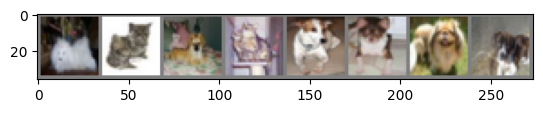

dog   cat   dog   cat   dog   dog   dog   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a function to turn the image back into something matplotlib can render
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(utils.make_grid(images))

# print labels
print(' '.join(f'{new_classes[labels[j]]:5s}' for j in range(batch_size)))

You can see from above that we have a lot of different types of dogs and cats, and these pictures are taken from different backgrounds and angles. Our model will need to learn a representation that's robust to these changes.

Now we can design our network.

In a Pytorch model definition, you indicate the layers that you want to use in the initialization, and then in the forward definition, you pass the data through these layers while applying any nonlinear functions that you need.

Generally, the first argument of one of these layers indicates the dimension of the input, and the second argument indicates the dimension of the output. Let's look at some of the lines here.

- **Conv2d**: apply a 2D convolution to the 3-channel (RGB) image, outputting 6-channel data, with a kernel size of 5.
- **MaxPool2d**: apply a 2D max pool of kernel size 2 with a stride of 2
- **Linear**: a fully-connected linear layer
- **F.relu**: apply the ReLU activation function

This pattern of convolution, relu, and pool is pretty common in deep convolutional networks, and you can see we apply it to our linear layers as well.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # final output is a vector of size 2 (dog & cat)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = Classifier()

We're going to be using cross entropy loss (which is common for classification problems) and optimize the model using gradient descent like we covered in the first notebook.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# This allows our model to be trained with the GPU, which is much faster
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
device

'cuda'

In [ ]:
epochs = 20

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()   # updates all of the weights with our loss
        optimizer.step()

    total, correct = 0, 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        # Convert raw logits to predicted class indices
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {100 * correct / total:.3f}')
    running_loss = 0.0

print('Finished training')

[1,  1000] accuracy: 54.200
[2,  1000] accuracy: 58.800
[3,  1000] accuracy: 61.650
[4,  1000] accuracy: 63.650
[5,  1000] accuracy: 60.000
[6,  1000] accuracy: 64.800
[7,  1000] accuracy: 65.000
[8,  1000] accuracy: 67.250
[9,  1000] accuracy: 66.350
[10,  1000] accuracy: 69.050
[11,  1000] accuracy: 68.200
[12,  1000] accuracy: 69.050
[13,  1000] accuracy: 69.400
[14,  1000] accuracy: 69.900
[15,  1000] accuracy: 68.100
[16,  1000] accuracy: 70.400
[17,  1000] accuracy: 70.200
[18,  1000] accuracy: 69.750
[19,  1000] accuracy: 69.100
[20,  1000] accuracy: 70.800
Finished training


You've trained your first neural network! It's not incredible, but it does significantly better than chance (50%).

Let's take a look at some of the model's predictions.

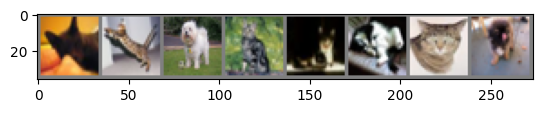

Correct labels:  cat   cat   dog   cat   cat   cat   cat   dog  
Predicted labels:  cat   dog   dog   dog   cat   dog   cat   dog  


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

with torch.no_grad(): # this tells the model to not learn anything from this input
  images = images.to(device)
  predictions = model(images).tolist()

prediction_labels = [np.argmax(prediction) for prediction in predictions]

# print images
imshow(utils.make_grid(images.cpu()))
print('Correct labels: ', ' '.join(f'{new_classes[labels[j]]:5s}' for j in range(8)))
print('Predicted labels: ', ' '.join(f'{new_classes[prediction_labels[j]]:5s}' for j in range(8)))

## What's necessary?

Okay so now I'd like to take a look at an example of a model which just doesn't have a robust enough architecture to learn the task.

The main thing we've done here is remove the convolutional layers. These allow the model to collect patterns in the image that it cares about, like what we looked at in our V1 neurons notebook. Now it only has information about each pixel. You can get some insight from that, but not a lot.

I'd also encourage you to remove the ReLU from this model. Nonlinearity allows models to make decisions about the flow of information, so it'll make a huge difference here.

In [ ]:
# flush our GPU so that the two models' trainings don't interact with each other
import gc
gc.collect()
torch.cuda.empty_cache()

class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc3 = nn.Linear(120, 2)

    def forward(self, x):
        # flatten the image to a vector of size 3072 for each image in the batch
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)

        return x

simple_model = SimpleLinearModel()
simple_model.to(device)

SimpleLinearModel(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters(), lr=0.001, momentum=0.9)

epochs = 10

for epoch in range(epochs):
  model.train()
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = simple_model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    total, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = simple_model(inputs)

      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {100 * correct / total:.3f}')

print('Finished training')

[1,  1000] accuracy: 59.650
[2,  1000] accuracy: 61.450
[3,  1000] accuracy: 61.900
[4,  1000] accuracy: 60.450
[5,  1000] accuracy: 62.050
[6,  1000] accuracy: 61.350
[7,  1000] accuracy: 60.400
[8,  1000] accuracy: 60.900
[9,  1000] accuracy: 61.500
[10,  1000] accuracy: 60.400
Finished training


Notice how this model struggles to learn to classify much better than chance. Let's look at our examples again.

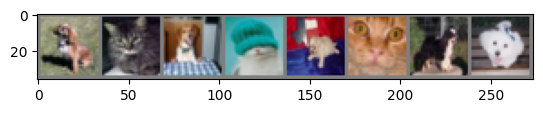

Correct labels:  dog   cat   dog   cat   dog   cat   dog   dog  
Predicted labels:  dog   cat   dog   cat   cat   dog   cat   cat  


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = next(dataiter)

with torch.no_grad(): # this tells the model to not learn anything from this input
  images = images.to(device)
  predictions = simple_model(images).tolist()

prediction_labels = [np.argmax(prediction) for prediction in predictions]

# print images
imshow(utils.make_grid(images.cpu()))
print('Correct labels: ', ' '.join(f'{new_classes[labels[j]]:5s}' for j in range(8)))
print('Predicted labels: ', ' '.join(f'{new_classes[prediction_labels[j]]:5s}' for j in range(8)))